# 1. VAE Implementation

## 1. Training Stage

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchsummary import summary

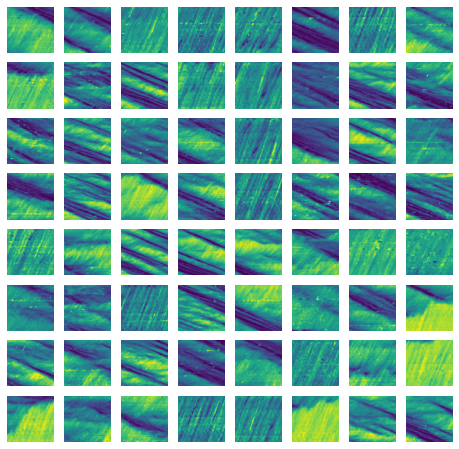

In [2]:
dataset = torch.load('dataset/i24_normalized.pt')

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(dataset[torch.randint(dataset.shape[0], (1,))][0][0], origin="lower" )
        ax[i, j].axis("off")
        
# Create data loaders
data_loader = DataLoader(dataset, batch_size=250, shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self, z_dim, input_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim

        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.enc_fc_mu = nn.Linear(128 * 8 * 8, z_dim)
        self.enc_fc_logvar = nn.Linear(128 * 8 * 8, z_dim)

        # Decoder
        self.dec_fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, input_dim, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.enc_conv(x)
        x = x.view(x.size(0), -1)
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = self.dec_fc(z)
        z = z.view(z.size(0), 128, 8, 8)
        z = self.dec_conv(z)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

![alt text](img/VAE_edit.png "Title")

The loss is defined as

- $ \begin{align} \mathcal{L}(\mathbf{x};\theta,\phi) &=  \mathbb{E}_{\mathbf{z} \sim q_{\phi} (\mathbf{z} | \mathbf{x})} \left[ \log p_{\theta}(\mathbf{x}|\mathbf{z})  \right]- D_{KL} \left( q_{\phi} \left(\mathbf{z}|\mathbf{x} \right) || p (\mathbf{z})  \right) \\ &= \text{Reconstruction Loss + Regularization} \end{align} $

The equation is simplified as

- $D_{KL}(\mathcal N_1({\mu_1, \sigma_1}^2)) || \mathcal N_2({\mu_2, \sigma_2}^2))=\log {\frac{\sigma_2}{\sigma_1}}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-{1\over 2}$
- $D_{KL}(\mathcal N_1({\mu_1, \sigma_1}^2))||\mathcal N(0, 1))=- \frac{1}{2}\left(1 + 2\log \sigma_1- \mu_1^2 -\sigma_1^2   \right)$

In [4]:
# Hyperparameters
z_dim = 64  # Size of the noise vector
lr = 0.0005
beta1 = 0.8

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = dataset.shape[1]
model = VAE(z_dim, input_dim).to(device)

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.98))

# Define the loss function
def criterion(recon_x, x, mu, logvar):
    # Reconstruction Loss: Measures how well the decoded output matches the input.
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # regularization: Measures how much the learned latent space diverges from the prior normal distribution.
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # we set logvar as 2*log(\sigma)
    return recon_loss + kl_loss

In [5]:
print('Change of dimension of the input of the VAE')
summary(model, (1, 64, 64))

Change of dimension of the input of the VAE
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             544
         LeakyReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,832
       BatchNorm2d-4           [-1, 64, 16, 16]             128
         LeakyReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6            [-1, 128, 8, 8]         131,200
       BatchNorm2d-7            [-1, 128, 8, 8]             256
         LeakyReLU-8            [-1, 128, 8, 8]               0
            Linear-9                   [-1, 64]         524,352
           Linear-10                   [-1, 64]         524,352
           Linear-11                 [-1, 8192]         532,480
             ReLU-12                 [-1, 8192]               0
  ConvTranspose2d-13           [-1, 64, 16, 16]         131

In [6]:
# Training loop

num_epochs = 50
model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for data in data_loader:
    
        optimizer.zero_grad()
        data = data.to(device)
        batch_size = data.size(0)
        recon_data, mu, logvar = model(data)
        loss = criterion(recon_data, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*batch_size
    
    avg_loss = train_loss/dataset.shape[0]
    
    if (epoch+1)%5 == 0:
        print(f'Epoch [{epoch+1:02}/{num_epochs}], Loss {avg_loss:>11.4f}')

# Save the model after training
torch.save(model.state_dict(), 'models/vae_model.pth')
print("VAE model saved.")

Epoch [05/50], Loss   9000.2087
Epoch [10/50], Loss   7941.2755
Epoch [15/50], Loss   7507.3223
Epoch [20/50], Loss   7373.7840
Epoch [25/50], Loss   7226.6777
Epoch [30/50], Loss   7213.4528
Epoch [35/50], Loss   7142.5683
Epoch [40/50], Loss   7094.2742
Epoch [45/50], Loss   7067.4855
Epoch [50/50], Loss   7033.7813
VAE model saved.


## 2. Testing Stage

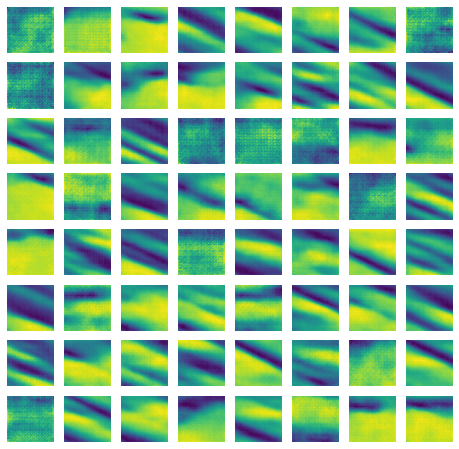

In [7]:
z_dim = 64
device = "cpu"

model = VAE(z_dim, input_dim).to(device)
model.load_state_dict(torch.load('models/vae_model.pth', map_location="cpu"))
model.eval()

# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = model.decode(z).cpu()
    sample = sample.numpy()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")

plt.savefig("img/VAE_result.png", dpi=500)
plt.show()